In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn


import utils as ut
import model as md
import run
import args

import time
from fastprogress import master_bar, progress_bar


import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim

import torchvision.transforms as transforms
import torchvision

from PIL import Image

In [2]:
def main():
    train_df, val_df = ut.dataloader()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    img_path = r"E:\Courses"
    train_dataset = ut.ChestXrayDataset(img_path,train_df, args.IMAGE_SIZE, True,'u-ones')
    val_dataset = ut.ChestXrayDataset(img_path, val_df, args.IMAGE_SIZE, True,'u-ones')

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=args.BATCH_SIZE, shuffle=True, 
                                  num_workers=0, pin_memory=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=args.BATCH_SIZE, shuffle=False, 
                                num_workers=0, pin_memory=True)
    
    model = md.DenseNet121(num_classes=args.NUM_CLASSES).to(device)
    
    # Loss function
    loss_criteria = nn.BCELoss()

    # Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=args.LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)

    # Learning rate will be reduced automatically during training
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=args.LEARNING_RATE_SCHEDULE_FACTOR, 
                                                        patience=args.LEARNING_RATE_SCHEDULE_PATIENCE, 
                                                        mode='max', verbose=True)
    
    best_score = 0
    model_path = "densenet.pth"
    training_losses = []
    validation_losses = []
    validation_score = []


    # Config progress bar
    mb = master_bar(range(5))
    mb.names = ['Training loss', 'Validation loss', 'Validation AUROC']
    x = []

    nonimproved_epoch = 0
    start_time = time.time()

    # Training each epoch
    for epoch in mb:
        mb.main_bar.comment = f'Best AUROC score: {best_score}'
        x.append(epoch)

        # Training
        train_loss = run.epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb)
        mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
        training_losses.append(train_loss)

        # Evaluating
        val_loss, new_score = run.evaluating(epoch, model, val_dataloader, device, loss_criteria, mb)
        mb.write('Finish validation epoch {} with loss {:.4f} and score {:.4f}'.format(epoch, val_loss, new_score))
        validation_losses.append(val_loss)
        validation_score.append(new_score)

        # Update learning rate
        lr_scheduler.step(new_score)

        # Update training chart
        mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score]], [0,epoch+1], [0,1])

        # Save model
        if best_score < new_score:
            mb.write(f"Improve AUROC from {best_score} to {new_score}")
            best_score = new_score
            nonimproved_epoch = 0
            torch.save({"model": model.state_dict(), 
                        "optimizer": optimizer.state_dict(), 
                        "best_score": best_score, 
                        "epoch": epoch, 
                        "lr_scheduler": lr_scheduler.state_dict()}, model_path)
        else: 
            nonimproved_epoch += 1
        if nonimproved_epoch > 10:
            break
            print("Early stopping")
        if time.time() - start_time > 3600*8:
            break
            print("Out of time")

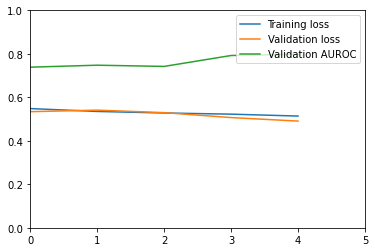

In [3]:
if __name__ =='__main__':
    main()

In [5]:
incept = torchvision.models.inception_v3(weights='Inception_V3_Weights.DEFAULT')

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\Hamid/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [6]:
incept

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [8]:
model_output_features = incept.fc.in_features

In [9]:
model_output_features

2048

In [12]:
incept.fc = nn.Sequential(nn.Linear(model_output_features, 4),
                                    nn.Sigmoid())

In [13]:
incept

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# Get the input dimension of last layer
model_output_features = self.model.fc.in_features

        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
self.model.fc = nn.Sequential(nn.Linear(model_output_features, num_classes),
                                              nn.Sigmoid())